In this notebook, I will build a tariff plan using the random forest refressor. I will organize the notebook like this:
- Fit in a random forest for frequency.
- Fit in a random forest for severity.
- Explain the results for frequency and severity separately.
- Analyze the resulting tariff plan.

Importing required packages for the analysis.

In [140]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import joblib  # save and load GridSearchCV objects

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import os
from datetime import datetime

Read the data.

In [67]:
data = pd.read_csv("../data/train.csv", index_col="Unnamed: 0")
data.head()

,AGEPH,CODPOSS,duree,lnexpo,nbrtotc,nbrtotan,chargtot,agecar,sexp,fuelc,split,usec,fleetc,sportc,coverp,powerc
11349,53,7500,1.000000,0.000000,0,0.00,0.000000,6-10,Female,Petrol,Once,Private,No,No,MTPL+,66-110
94835,42,3090,0.684932,-0.378436,1,1.46,65.691784,2-5,Male,Petrol,Monthly,Private,No,No,MTPL,<66
71207,63,3800,1.000000,0.000000,0,0.00,0.000000,2-5,Male,Gasoil,Once,Private,No,No,MTPL,<66
76198,38,4360,0.698630,-0.358634,0,0.00,0.000000,2-5,Male,Petrol,Once,Private,No,No,MTPL+,66-110
20614,26,7130,1.000000,0.000000,0,0.00,0.000000,2-5,Female,Petrol,Once,Private,No,No,MTPL,<66


Post-codes are purely categorical (not ordinal) with a lot of levels, one-hot encoding or even embedding into $\mathbb{N}$ makes little sense. However, I don't want to throw away the spatial info, since it may play an effect. Instead of working with CODPOSS, I will instead work with latitudes and longitudes.

In [72]:
def postcodes_to_latlong(df: pd.DataFrame):
    spatial = pd.read_excel("../initial_docs/inspost.xls")
    spatial.drop(columns=["INS", "COMMUNE"], inplace=True)  # we do not need these info
    tmp_df = pd.merge(data, spatial, how="left", on="CODPOSS")
    tmp_df.drop(columns="CODPOSS", inplace=True)
    
    return tmp_df

In [74]:
data2 = postcodes_to_latlong(data)
data2.head()

,AGEPH,duree,lnexpo,nbrtotc,nbrtotan,chargtot,agecar,sexp,fuelc,split,usec,fleetc,sportc,coverp,powerc,LAT,LONG
0,53,1.000000,0.000000,0,0.00,0.000000,6-10,Female,Petrol,Once,Private,No,No,MTPL+,66-110,50.600000,3.383333
1,42,0.684932,-0.378436,1,1.46,65.691784,2-5,Male,Petrol,Monthly,Private,No,No,MTPL,<66,50.766667,4.533333
2,63,1.000000,0.000000,0,0.00,0.000000,2-5,Male,Gasoil,Once,Private,No,No,MTPL,<66,50.800000,5.183333
3,38,0.698630,-0.358634,0,0.00,0.000000,2-5,Male,Petrol,Once,Private,No,No,MTPL+,66-110,50.716667,5.350000
4,26,1.000000,0.000000,0,0.00,0.000000,2-5,Female,Petrol,Once,Private,No,No,MTPL,<66,50.400000,4.150000


We will need to convert the categoricals here into numeric, since SKLearn only works with numerics. *agecar, split, coverp*, and *powerc* have more than two levels, but fortunately they are ordinals, so it splitting on <2 makes more sense (compared to when you have pure categorical, splitting on <2 is very arbitrary).

In [75]:
categoricals = data2.select_dtypes(include=np.object_).columns
for category in categoricals:
    print(category + ":", data2[category].unique())

agecar: ['6-10' '2-5' '>10' '0-1']
sexp: ['Female' 'Male']
fuelc: ['Petrol' 'Gasoil']
split: ['Once' 'Monthly' 'Twice' 'Thrice']
usec: ['Private' 'Professional']
fleetc: ['No' 'Yes']
sportc: ['No' 'Yes']
coverp: ['MTPL+' 'MTPL' 'MTPL+++']
powerc: ['66-110' '<66' '>110']


In [76]:
data2['agecar'] = data2['agecar'].map({"0-1": 0, "2-5": 1, "6-10":2, ">10": 3})
data2['sexp'] = data2['sexp'].map({"Male": 0, "Female": 1})
data2['fuelc'] = data2['fuelc'].map({"Petrol": 0, "Gasoil": 1})
data2['split'] = data2['split'].map({"Once": 0, "Monthly": 1, "Twice":2, "Thrice": 3})
data2['usec'] = data2['usec'].map({"Private": 0, "Professional": 1})
data2['fleetc'] = data2['fleetc'].map({"Yes": 0, "No": 1})
data2['sportc'] = data2['sportc'].map({"Yes": 0, "No": 1})
data2['coverp'] = data2['coverp'].map({"MTPL": 0, "MTPL+": 1, "MTPL+++":2})
data2['powerc'] = data2['powerc'].map({"<66": 0, "66-110": 1, ">110":2})

for category in categoricals:
    print(category + ":", data2[category].unique())

agecar: [2 1 3 0]
sexp: [1 0]
fuelc: [0 1]
split: [0 1 2 3]
usec: [0 1]
fleetc: [1 0]
sportc: [1 0]
coverp: [1 0 2]
powerc: [1 0 2]


Partitioning the data into features and targets.

In [104]:
features = ["AGEPH", "LAT", "LONG"] + list(categoricals)  # list addition is concatenation

freq_target = data2['nbrtotc']/data2['duree']
freq_weights = data2['duree']
freq_features = data2.loc[:, features]

sev_data2 = data2.query("nbrtotc > 0")

sev_target = sev_data2['chargtot']/sev_data2['nbrtotc']
sev_weights = sev_data2['nbrtotc']
sev_features = sev_data2.loc[:, features]

freq_features.head()

,AGEPH,LAT,LONG,agecar,sexp,fuelc,split,usec,fleetc,sportc,coverp,powerc
0,53,50.600000,3.383333,2,1,0,0,0,1,1,1,1
1,42,50.766667,4.533333,1,0,0,1,0,1,1,0,0
2,63,50.800000,5.183333,1,0,1,0,0,1,1,0,0
3,38,50.716667,5.350000,1,0,0,0,0,1,1,1,1
4,26,50.400000,4.150000,1,1,0,0,0,1,1,0,0


## Fitting in frequency.

In another class, it was highlighted that RandomForests do not require tuning for depth and number of trees, simply the more the merrier. This simplifies the grid search, and I will be able to check out more values for *max_features* and *max_samples*.

Below is an estimate on how long one parameter configuration will take. Five hundred trees takes twelve seconds, I think that is workable. The only hyperparameters I will tune are *max_features* and *max_samples*, and I will partition them on a coarser grid to begin with. After checking the results, I will try a refined grid, with more trees as well.

I think that *min_weight_fraction_leaf* at $1\%$ is reasonable for frequency, as this is more than 1k observations.

In [127]:
_ = RandomForestRegressor(n_estimators=500, criterion="poisson", max_depth=7,
                                min_samples_split=0.05, min_weight_fraction_leaf=0.01, random_state=0,
                                max_features="sqrt", max_samples=0.6)

now = datetime.now()
_.fit(X=freq_features, y=freq_target, sample_weight=freq_weights)

print(f"Time taken = {(datetime.now() - now).seconds} seconds")

Time taken = 12 seconds


Set up the param-grid and base estimator. Assuming 12 seconds run per configuration on a single fold, with 5-fold CV that means a minute fore every point on the grid. I impose a strict budget of 15-minutes, which is reflected on the parameter grid below.

In [145]:
freq_param_grid = {"max_features": [2, 3, 4, 6, 8],
                   "max_samples": [0.3, 0.5, 0.7]}

freq_rf = RandomForestRegressor(n_estimators=500, criterion="poisson", max_depth=7,
                                min_samples_split=0.05, min_weight_fraction_leaf=0.01, random_state=0)

Kick off the search. Also, save the results, since this is a long calculation.

In [149]:
# freq_grid = GridSearchCV(freq_rf, freq_param_grid, scoring="neg_mean_poisson_deviance", cv=5, refit=False, verbose=1)

now = datetime.now()
# freq_grid.fit(X=freq_features, y=freq_target, sample_weight=freq_weights)
print(f"Time taken {(datetime.now() - now).seconds} seconds")

# joblib.dump(freq_grid, "../models/initial_freq_grid.pkl")

# joblib.load("../models/initial_freq_grid.pkl")

Time taken 0 seconds


Plotting the mean deviances, the lower the better. The trend is very straightforward, higher *max_sample* performs better, lower *max_features* performs better. Since number of features each split is only 2, that means we needed uncorrelated trees.

In [231]:
results = freq_grid.cv_results_
results_df = pd.DataFrame({"max_features": results["param_max_features"].data,
                           "max_samples": results["param_max_samples"].data,
                           "rank": results["rank_test_score"],
                           "mean_test_score": -results["mean_test_score"]})  # remove the negative
results_df = results_df.sort_values(["max_samples", "max_features"])

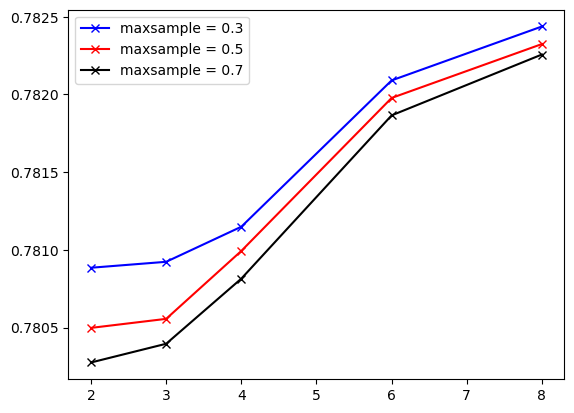

In [338]:
maxsample_pointthree = results_df.query("max_samples==0.3").filter(["max_features", "mean_test_score"])
maxsample_pointfive = results_df.query("max_samples==0.5").filter(["max_features", "mean_test_score"])
maxsample_pointseven = results_df.query("max_samples==0.7").filter(["max_features", "mean_test_score"])

plt.plot(maxsample_pointthree.iloc[:, 0], maxsample_pointthree.iloc[:, 1], "blue", marker="x")
plt.plot(maxsample_pointfive.iloc[:, 0], maxsample_pointfive.iloc[:, 1], "red", marker="x")
plt.plot(maxsample_pointseven.iloc[:, 0], maxsample_pointseven.iloc[:, 1], "black", marker="x")

plt.legend(["maxsample = 0.3", "maxsample = 0.5", "maxsample = 0.7"])
plt.show()

In [222]:
maxsample_pointthree.iloc[:, 0]

0     2
3     3
6     4
9     6
12    8
Name: max_features, dtype: object

Refined grid search, increased number of trees from 500 to 1000 as well.

In [274]:
freq_param_grid_final = freq_param_grid = {"max_features": [1, 2],
                                           "max_samples": [0.65, 0.7, 0.75, 0.8, 0.85]}
freq_rf2 = RandomForestRegressor(n_estimators=1000, criterion="poisson", max_depth=7,
                                min_samples_split=0.05, min_weight_fraction_leaf=0.01, random_state=0)

freq_grid_final = GridSearchCV(freq_rf2, freq_param_grid_final, scoring="neg_mean_poisson_deviance",
                               cv=5, refit=False, verbose=1)

now = datetime.now()
freq_grid_final.fit(X=freq_features, y=freq_target, sample_weight=freq_weights)
print(f"Time taken {(datetime.now() - now).seconds} seconds")

joblib.dump(freq_grid, "../models/final_freq_grid.pkl")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Time taken 703 seconds


['../models/final_freq_grid.pkl']

In [275]:
results2 = freq_grid_final.cv_results_
results2_df = pd.DataFrame({"max_features": results2["param_max_features"].data,
                           "max_samples": results2["param_max_samples"].data,
                           "rank": results2["rank_test_score"],
                           "mean_test_score": -results2["mean_test_score"]})  # remove the negative
results2_df = results2_df.sort_values(["max_samples", "max_features"])

results2_df

,max_features,max_samples,rank,mean_test_score
0,1,0.65,10,0.782251
5,2,0.65,5,0.780345
1,1,0.7,9,0.782217
6,2,0.7,4,0.780307
2,1,0.75,8,0.782191
7,2,0.75,3,0.780259
3,1,0.8,7,0.782174
8,2,0.8,2,0.780225
4,1,0.85,6,0.782156
9,2,0.85,1,0.780171


It is only slightly better.

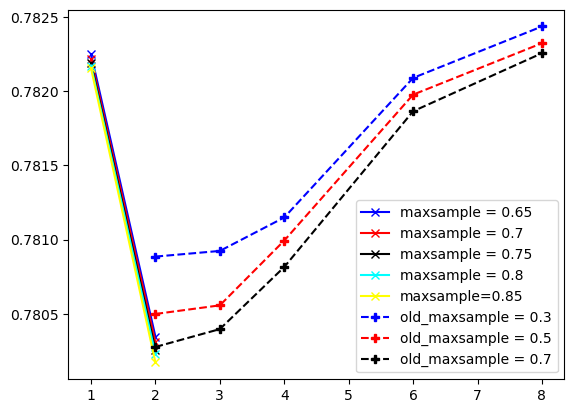

In [340]:
a1 = results2_df.query("max_samples==0.65").filter(["max_features", "mean_test_score"])
a2 = results2_df.query("max_samples==0.7").filter(["max_features", "mean_test_score"])
a3 = results2_df.query("max_samples==0.75").filter(["max_features", "mean_test_score"])
a4 = results2_df.query("max_samples==0.80").filter(["max_features", "mean_test_score"])
a5 = results2_df.query("max_samples==0.85").filter(["max_features", "mean_test_score"])

plt.plot(a1.iloc[:, 0], a1.iloc[:, 1], "blue", marker="x")
plt.plot(a2.iloc[:, 0], a2.iloc[:, 1], "red", marker="x")
plt.plot(a3.iloc[:, 0], a3.iloc[:, 1], "black", marker="x")
plt.plot(a4.iloc[:, 0], a4.iloc[:, 1], "cyan", marker="x")
plt.plot(a5.iloc[:, 0], a5.iloc[:, 1], "yellow", marker="x")

plt.plot(maxsample_pointthree.iloc[:, 0], maxsample_pointthree.iloc[:, 1], "blue", linestyle="dashed", marker="P")
plt.plot(maxsample_pointfive.iloc[:, 0], maxsample_pointfive.iloc[:, 1], "red", linestyle="dashed", marker="P")
plt.plot(maxsample_pointseven.iloc[:, 0], maxsample_pointseven.iloc[:, 1], "black", linestyle="dashed", marker="P")

plt.legend(["maxsample = 0.65", "maxsample = 0.7", "maxsample = 0.75", "maxsample = 0.8", "maxsample=0.85",
            "old_maxsample = 0.3", "old_maxsample = 0.5", "old_maxsample = 0.7"])
plt.show()

Retrain final model with full trainset.

In [279]:
freq_rf_final = RandomForestRegressor(n_estimators=1000, criterion="poisson", max_depth=7,
                                      min_samples_split=0.05, min_weight_fraction_leaf=0.01, random_state=0,
                                      max_features=2, max_samples=0.85)
freq_rf_final.fit(X=freq_features, y=freq_target, sample_weight=freq_weights)

RandomForestRegressor(criterion='poisson', max_depth=7, max_features=2,
                      max_samples=0.85, min_samples_split=0.05,
                      min_weight_fraction_leaf=0.01, n_estimators=1000,
                      random_state=0)

Save final frequency model.

In [280]:
joblib.dump(freq_rf_final, "../models/freq_rf.pkl")

['../models/freq_rf.pkl']

## Fitting in severity.

Now I will find a severity model. With only 12k observations, I expect computations are much faster so we can use even more trees and put more points on the parameters grid.

An interesting thing we can try is using both *squared_error* and *absolute_error* as criterions. Since we have some insane outliers, using *absolute_error* might prevent each trees from latching on to the extreme outliers.

We only needed 4 seconds, I will be generous with the parameter grid. [UPDATE:] Deciding to be generous and not calculating time taken is a bad mistake, I just realized that it will take 70 mins to finish the calculations.

In [261]:
now = datetime.now()
sev_rf = RandomForestRegressor(n_estimators=1000, criterion="squared_error", max_depth=7,
                               min_samples_split=0.05, min_weight_fraction_leaf=0.01, random_state=0,
                               max_features=5, max_samples=0.8)
sev_rf.fit(X=sev_features, y=sev_target, sample_weight=sev_weights)
print(f"Took {(datetime.now()-now).seconds} seconds")

Took 4 seconds


Creating initial coarse parameter grid.

In [277]:
sev_param_grid = {"criterion": ["squared_error", "absolute_error"],
                  "max_features": [2, 4, 6],
                  "max_samples": [0.7, 0.8, 0.9],
                  "max_depth": [7, 9]}

sev_initial_rf = RandomForestRegressor(n_estimators=1000, min_samples_split=0.05,
                                       min_weight_fraction_leaf=0.01, random_state=0)

Perform the grid search, and save the model.

In [278]:
now = datetime.now()

sev_initial_grid = GridSearchCV(estimator=sev_initial_rf, param_grid=sev_param_grid,
                                scoring="neg_mean_gamma_deviance", refit=False, verbose=2, cv=5)
# sev_initial_grid.fit(X=sev_features, y=sev_target, sample_weight=sev_weights)

print(f"Took {(datetime.now()-now).seconds} seconds")

# joblib.dump(sev_initial_grid, "../models/initial_sev_grid.pkl")

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END criterion=squared_error, max_depth=7, max_features=2, max_samples=0.7; total time=   2.0s
[CV] END criterion=squared_error, max_depth=7, max_features=2, max_samples=0.7; total time=   2.0s
[CV] END criterion=squared_error, max_depth=7, max_features=2, max_samples=0.7; total time=   2.1s
[CV] END criterion=squared_error, max_depth=7, max_features=2, max_samples=0.7; total time=   2.1s
[CV] END criterion=squared_error, max_depth=7, max_features=2, max_samples=0.7; total time=   2.4s
[CV] END criterion=squared_error, max_depth=7, max_features=2, max_samples=0.8; total time=   2.3s
[CV] END criterion=squared_error, max_depth=7, max_features=2, max_samples=0.8; total time=   2.1s
[CV] END criterion=squared_error, max_depth=7, max_features=2, max_samples=0.8; total time=   2.2s
[CV] END criterion=squared_error, max_depth=7, max_features=2, max_samples=0.8; total time=   2.1s
[CV] END criterion=squared_error, max_depth=7, 

[CV] END criterion=squared_error, max_depth=9, max_features=6, max_samples=0.8; total time=   4.5s
[CV] END criterion=squared_error, max_depth=9, max_features=6, max_samples=0.8; total time=   5.2s
[CV] END criterion=squared_error, max_depth=9, max_features=6, max_samples=0.9; total time=   5.2s
[CV] END criterion=squared_error, max_depth=9, max_features=6, max_samples=0.9; total time=   5.3s
[CV] END criterion=squared_error, max_depth=9, max_features=6, max_samples=0.9; total time=   4.9s
[CV] END criterion=squared_error, max_depth=9, max_features=6, max_samples=0.9; total time=   5.8s
[CV] END criterion=squared_error, max_depth=9, max_features=6, max_samples=0.9; total time=   6.4s
[CV] END criterion=absolute_error, max_depth=7, max_features=2, max_samples=0.7; total time= 2.3min
[CV] END criterion=absolute_error, max_depth=7, max_features=2, max_samples=0.7; total time= 2.5min
[CV] END criterion=absolute_error, max_depth=7, max_features=2, max_samples=0.7; total time= 2.5min
[CV] EN

[CV] END criterion=absolute_error, max_depth=9, max_features=6, max_samples=0.7; total time= 5.4min
[CV] END criterion=absolute_error, max_depth=9, max_features=6, max_samples=0.7; total time= 5.5min
[CV] END criterion=absolute_error, max_depth=9, max_features=6, max_samples=0.7; total time= 5.1min
[CV] END criterion=absolute_error, max_depth=9, max_features=6, max_samples=0.7; total time= 5.6min
[CV] END criterion=absolute_error, max_depth=9, max_features=6, max_samples=0.7; total time= 5.3min
[CV] END criterion=absolute_error, max_depth=9, max_features=6, max_samples=0.8; total time= 6.5min
[CV] END criterion=absolute_error, max_depth=9, max_features=6, max_samples=0.8; total time= 6.4min
[CV] END criterion=absolute_error, max_depth=9, max_features=6, max_samples=0.8; total time= 6.0min
[CV] END criterion=absolute_error, max_depth=9, max_features=6, max_samples=0.8; total time= 6.5min
[CV] END criterion=absolute_error, max_depth=9, max_features=6, max_samples=0.8; total time= 6.1min


['../models/initial_sev_grid.pkl']

In [288]:
sev_results = sev_initial_grid.cv_results_
sev_results_df = pd.DataFrame({"max_features": sev_results["param_max_features"].data,
                               "max_samples": sev_results["param_max_samples"].data,
                               "rank": sev_results["rank_test_score"],
                               "mean_test_score": -sev_results["mean_test_score"],
                               "criterion": sev_results["param_criterion"],
                               "max_depth": sev_results["param_max_depth"]})  # remove the negative
sev_results_df = sev_results_df.sort_values(["criterion", "max_depth", "max_samples", "max_features"])

sev_results_df

,max_features,max_samples,rank,mean_test_score,criterion,max_depth
18,2,0.7,20,4.500497,absolute_error,7
21,4,0.7,26,4.626223,absolute_error,7
24,6,0.7,32,4.702201,absolute_error,7
19,2,0.8,19,4.499684,absolute_error,7
22,4,0.8,27,4.640479,absolute_error,7
25,6,0.8,35,4.731635,absolute_error,7
20,2,0.9,21,4.506750,absolute_error,7
23,4,0.9,30,4.655836,absolute_error,7
26,6,0.9,36,4.740943,absolute_error,7
27,2,0.7,22,4.510542,absolute_error,9


Plotting the results.

In [302]:
ae_depthseven_pointseven = sev_results_df.iloc[0:3, [0, 3]]
ae_depthseven_pointeight = sev_results_df.iloc[3:6, [0, 3]]
ae_depthseven_pointnine = sev_results_df.iloc[6:9, [0, 3]]

ae_depthnine_pointseven = sev_results_df.iloc[9:12, [0, 3]]
ae_depthnine_pointeight = sev_results_df.iloc[12:15, [0, 3]]
ae_depthnine_pointnine = sev_results_df.iloc[15:18, [0, 3]]

se_depthseven_pointseven = sev_results_df.iloc[18:21, [0, 3]]
se_depthseven_pointeight = sev_results_df.iloc[21:24, [0, 3]]
se_depthseven_pointnine = sev_results_df.iloc[24:27, [0, 3]]

se_depthnine_pointseven = sev_results_df.iloc[27:30, [0, 3]]
se_depthnine_pointeight = sev_results_df.iloc[30:33, [0, 3]]
se_depthnine_pointnine = sev_results_df.iloc[33:36, [0, 3]]

The conclusion here is that despite taking 7 hours of computation time, checking out mean absolute error was useless. Looks like *max_sample* has more of an effect compared to *max_depth*, but *max_depth* does have an effect. It seems lower *max_depth* with higher *max_sample* is better,

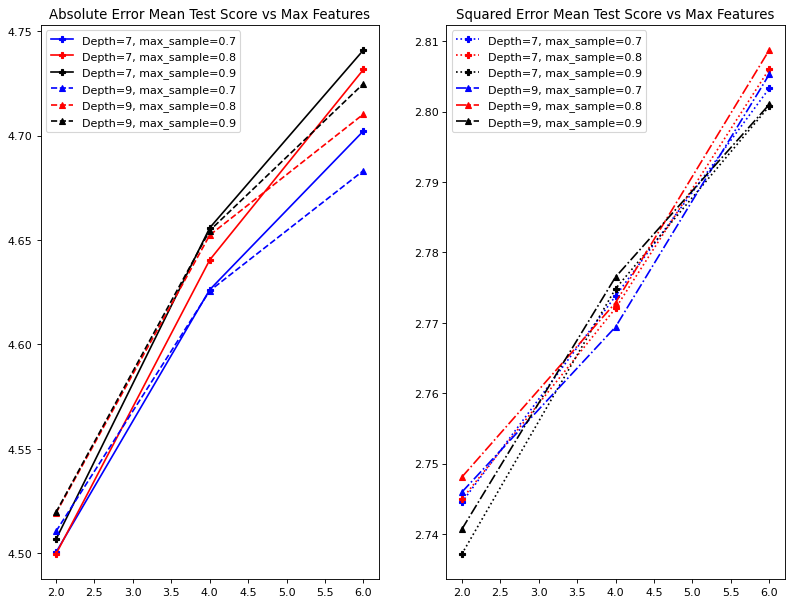

In [341]:
plt.figure(figsize=(12, 9), dpi=80)

plt.subplot(1, 2, 1)

plt.plot(ae_depthseven_pointseven.iloc[:, 0], ae_depthseven_pointseven.iloc[:, 1], "blue", marker="P")
plt.plot(ae_depthseven_pointeight.iloc[:, 0], ae_depthseven_pointeight.iloc[:, 1], "red", marker="P")
plt.plot(ae_depthseven_pointnine.iloc[:, 0], ae_depthseven_pointnine.iloc[:, 1], "black", marker="P")

plt.plot(ae_depthnine_pointseven.iloc[:, 0], ae_depthnine_pointseven.iloc[:, 1], "blue", linestyle="dashed", marker="^")
plt.plot(ae_depthnine_pointeight.iloc[:, 0], ae_depthnine_pointeight.iloc[:, 1], "red", linestyle="dashed", marker="^")
plt.plot(ae_depthnine_pointnine.iloc[:, 0], ae_depthnine_pointnine.iloc[:, 1], "black", linestyle="dashed", marker="^")

plt.legend(["Depth=7, max_sample=0.7", "Depth=7, max_sample=0.8", "Depth=7, max_sample=0.9",
            "Depth=9, max_sample=0.7", "Depth=9, max_sample=0.8", "Depth=9, max_sample=0.9"])
plt.title("Absolute Error Mean Test Score vs Max Features")

plt.subplot(1, 2, 2)

plt.plot(se_depthseven_pointseven.iloc[:, 0], se_depthseven_pointseven.iloc[:, 1], "blue", linestyle="dotted", marker="P")
plt.plot(se_depthseven_pointeight.iloc[:, 0], se_depthseven_pointeight.iloc[:, 1], "red", linestyle="dotted", marker="P")
plt.plot(se_depthseven_pointnine.iloc[:, 0], se_depthseven_pointnine.iloc[:, 1], "black", linestyle="dotted", marker="P")

plt.plot(se_depthnine_pointseven.iloc[:, 0], se_depthnine_pointseven.iloc[:, 1], "blue", linestyle="dashdot", marker="^")
plt.plot(se_depthnine_pointeight.iloc[:, 0], se_depthnine_pointeight.iloc[:, 1], "red", linestyle="dashdot", marker="^")
plt.plot(se_depthnine_pointnine.iloc[:, 0], se_depthnine_pointnine.iloc[:, 1], "black", linestyle="dashdot", marker="^")

plt.legend(["Depth=7, max_sample=0.7", "Depth=7, max_sample=0.8", "Depth=7, max_sample=0.9",
            "Depth=9, max_sample=0.7", "Depth=9, max_sample=0.8", "Depth=9, max_sample=0.9"])
plt.title("Squared Error Mean Test Score vs Max Features")

plt.show()

I will now refine the parameter grid.

In [313]:
sev_param_grid2 = {"max_features": [2, 4, 6],
                  "max_samples": [0.9, 0.95],
                  "max_depth": [3, 4, 5, 6]}

sev_initial_rf2 = RandomForestRegressor(n_estimators=1000, min_samples_split=0.05, criterion="squared_error", max_features=2,
                                        min_weight_fraction_leaf=0.01, random_state=0)

In [314]:
now = datetime.now()

sev_final_grid = GridSearchCV(estimator=sev_initial_rf2, param_grid=sev_param_grid2,
                                scoring="neg_mean_gamma_deviance", refit=True, verbose=2, cv=5)
# sev_final_grid.fit(X=sev_features, y=sev_target, sample_weight=sev_weights)

print(f"Took {(datetime.now()-now).seconds} seconds")

# joblib.dump(sev_initial_grid, "../models/final_sev_grid.pkl")

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END .......max_depth=3, max_features=2, max_samples=0.9; total time=   2.2s
[CV] END .......max_depth=3, max_features=2, max_samples=0.9; total time=   1.9s
[CV] END .......max_depth=3, max_features=2, max_samples=0.9; total time=   1.8s
[CV] END .......max_depth=3, max_features=2, max_samples=0.9; total time=   1.9s
[CV] END .......max_depth=3, max_features=2, max_samples=0.9; total time=   1.9s
[CV] END ......max_depth=3, max_features=2, max_samples=0.95; total time=   1.9s
[CV] END ......max_depth=3, max_features=2, max_samples=0.95; total time=   2.0s
[CV] END ......max_depth=3, max_features=2, max_samples=0.95; total time=   2.3s
[CV] END ......max_depth=3, max_features=2, max_samples=0.95; total time=   2.9s
[CV] END ......max_depth=3, max_features=2, max_samples=0.95; total time=   3.0s
[CV] END .......max_depth=3, max_features=4, max_samples=0.9; total time=   5.0s
[CV] END .......max_depth=3, max_features=4, ma

[CV] END .......max_depth=6, max_features=4, max_samples=0.9; total time=   5.2s
[CV] END .......max_depth=6, max_features=4, max_samples=0.9; total time=   4.4s
[CV] END .......max_depth=6, max_features=4, max_samples=0.9; total time=   4.0s
[CV] END .......max_depth=6, max_features=4, max_samples=0.9; total time=   4.4s
[CV] END ......max_depth=6, max_features=4, max_samples=0.95; total time=   5.5s
[CV] END ......max_depth=6, max_features=4, max_samples=0.95; total time=   5.5s
[CV] END ......max_depth=6, max_features=4, max_samples=0.95; total time=   5.7s
[CV] END ......max_depth=6, max_features=4, max_samples=0.95; total time=   7.2s
[CV] END ......max_depth=6, max_features=4, max_samples=0.95; total time=   4.1s
[CV] END .......max_depth=6, max_features=6, max_samples=0.9; total time=   5.6s
[CV] END .......max_depth=6, max_features=6, max_samples=0.9; total time=   5.8s
[CV] END .......max_depth=6, max_features=6, max_samples=0.9; total time=   5.2s
[CV] END .......max_depth=6,

['../models/final_sev_grid.pkl']

In [329]:
sev_results2 = sev_final_grid.cv_results_

sev_results_df2 = pd.DataFrame({"max_depth": sev_results2["param_max_depth"],
                                "max_features": sev_results2["param_max_features"],
                                "max_samples": sev_results2["param_max_samples"],
                                "rank":sev_results2["rank_test_score"],
                                "mean_test_score": -sev_results2["mean_test_score"]})

sev_results_df2 = sev_results2_df.sort_values(["max_depth", "max_samples", "max_features"])
sev_results_df2

,max_depth,max_features,max_samples,rank,mean_test_score
0,3,2,0.9,1,2.727333
2,3,4,0.9,10,2.755973
4,3,6,0.9,18,2.776871
1,3,2,0.95,2,2.727584
3,3,4,0.95,9,2.755390
5,3,6,0.95,16,2.774839
6,4,2,0.9,5,2.732241
8,4,4,0.9,11,2.761697
10,4,6,0.9,20,2.791774
7,4,2,0.95,6,2.733909


Plotting the results.

In [330]:
depththree_ninety = sev_results_df2.iloc[0:3, [1, 4]]
depththree_ninetyfive = sev_results_df2.iloc[3:6, [1, 4]]

depthfour_ninety = sev_results_df2.iloc[6:9, [1, 4]]
depthfour_ninetyfive = sev_results_df2.iloc[9:12, [1, 4]]

depthfive_ninety = sev_results_df2.iloc[12:15, [1, 4]]
depthfive_ninetyfive = sev_results_df2.iloc[15:18, [1, 4]]

depthsix_ninety = sev_results_df2.iloc[18:21, [1, 4]]
depthsix_ninetyfive = sev_results_df2.iloc[21:24, [1, 4]]

Again the conclusion is that a lower *max_depth* and lower *max_features* is better. Looks like *max_sample* is best at point nine.

Text(0.5, 1.0, 'Mean Test Score vs Max Features')

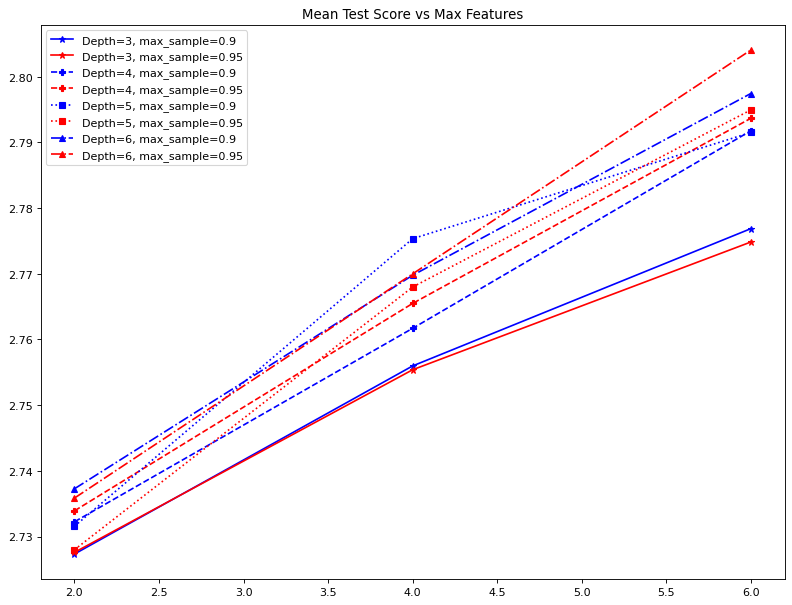

In [335]:
plt.figure(figsize=(12, 9), dpi=80)

plt.plot(depththree_ninety.iloc[:, 0], depththree_ninety.iloc[:, 1], "blue", marker="*")
plt.plot(depththree_ninetyfive.iloc[:, 0], depththree_ninetyfive.iloc[:, 1], "red", marker="*")

plt.plot(depthfour_ninety.iloc[:, 0], depthfour_ninety.iloc[:, 1], "blue", linestyle="dashed", marker="P")
plt.plot(depthfour_ninetyfive.iloc[:, 0], depthfour_ninetyfive.iloc[:, 1], "red", linestyle="dashed", marker="P")

plt.plot(depthfive_ninety.iloc[:, 0], depthfive_ninety.iloc[:, 1], "blue", linestyle="dotted", marker="s")
plt.plot(depthfive_ninetyfive.iloc[:, 0], depthfive_ninetyfive.iloc[:, 1], "red", linestyle="dotted", marker="s")

plt.plot(depthsix_ninety.iloc[:, 0], depthsix_ninety.iloc[:, 1], "blue", linestyle="dashdot", marker="^")
plt.plot(depthsix_ninetyfive.iloc[:, 0], depthsix_ninetyfive.iloc[:, 1], "red", linestyle="dashdot", marker="^")

plt.legend(["Depth=3, max_sample=0.9", "Depth=3, max_sample=0.95",
            "Depth=4, max_sample=0.9", "Depth=4, max_sample=0.95",
            "Depth=5, max_sample=0.9", "Depth=5, max_sample=0.95",
            "Depth=6, max_sample=0.9", "Depth=6, max_sample=0.95"])
plt.title("Mean Test Score vs Max Features")

Get and save final model.

In [337]:
sev_rf_final = sev_final_grid.best_estimator_

# joblib.dump(sev_rf_final, "../models/sev_rf.pkl")

['../models/sev_rf.pkl']

## Explaining the model.

In [327]:
depthsix_ninety

,max_samples,criterion
0,0.7,squared_error
3,0.7,squared_error
6,0.7,squared_error
